### Exploratory Data Analysis on ATL03

To do:
    
    - is there any relation between the number of photons and the slope/smoothness of the surface 
    - Maximum likehood criteria for fiiting a surface. Based on the overall likehood, maybe we can infer how clean is the surface

In [2]:
from icepyx import icesat2data as ipd
import numpy as np
import os
import h5py
import shutil
from pathlib import Path
from pprint import pprint
from random import sample

from os import listdir
from os.path import isfile, join

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

from utils_atl03 import *

plt.rcParams['figure.figsize'] = [25, 20]
#plt.style.use('seaborn-white')

In [3]:
def interquantile(l):
    
    return np.quantile(l, .75) - np.quantile(l, .25)

# ATL03 Retrieval

### Example 1: Finding a lake in Greenland

In [4]:
my_lat = 68.4547
my_lon = -47.6758
date_range = ['2019-08-01','2019-08-03']

In [8]:
pho = read_atl03(my_lat, my_lon, date_range, 1000)
#pho.to_csv('pho.csv')
#pho = pd.read_csv("pho.csv", index_col=0)

In [28]:
pho.index

RangeIndex(start=0, stop=4923540, step=1)

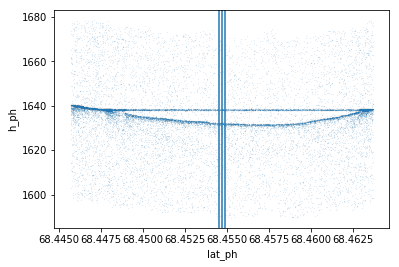

In [8]:
ax2 = pho.plot.scatter(x='lat_ph',
                       y='h_ph',
                       #c='lat_ph',
                       s = 0.002) # colormap='viridis'
plt.axvline(x = my_lat)
plt.axvline(x = my_lat + delta_lat(my_lat, my_lon, 20))
plt.axvline(x = my_lat - delta_lat(my_lat, my_lon, 20))

A histogram can help us to see that there are two different surfaces

## Unsupervised

In [7]:
spatial_extend = [-72.08864, 25.96263, -69.74056, 33.16826]

#spatial_extend = [25.96263, -72.08864, 33.16826, -69.74056]
#spatial_extend = [28.96263, -71.08864, 29.16826, -69.74056]


date_range = ['2020-01-01','2020-01-10']

#pho = read_atl03(-1, -1, date_range, 1000, path = "new_ATL03_unsupervised", extent = spatial_extend)

In [9]:
#pho.to_csv('pho_Antarctica_unsupervised.csv')
pho = pd.read_csv("pho_Antarctica_unsupervised.csv", index_col=0)
pho.head()

/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,h_ph,lon_ph,lat_ph,ground_track
0,-51.197240,-70.419647,26.997163,gt1r
1,-51.406040,-70.419647,26.997163,gt1r
2,-51.061940,-70.419648,26.997170,gt1r
3,-51.152588,-70.419649,26.997176,gt1r
4,-50.986930,-70.419649,26.997182,gt1r


In [10]:
np.unique(pho.ground_track, return_counts=True )

(array(['gt1r', 'gt2r', 'gt3r'], dtype=object),
 array([1874352, 1366851, 1682337]))

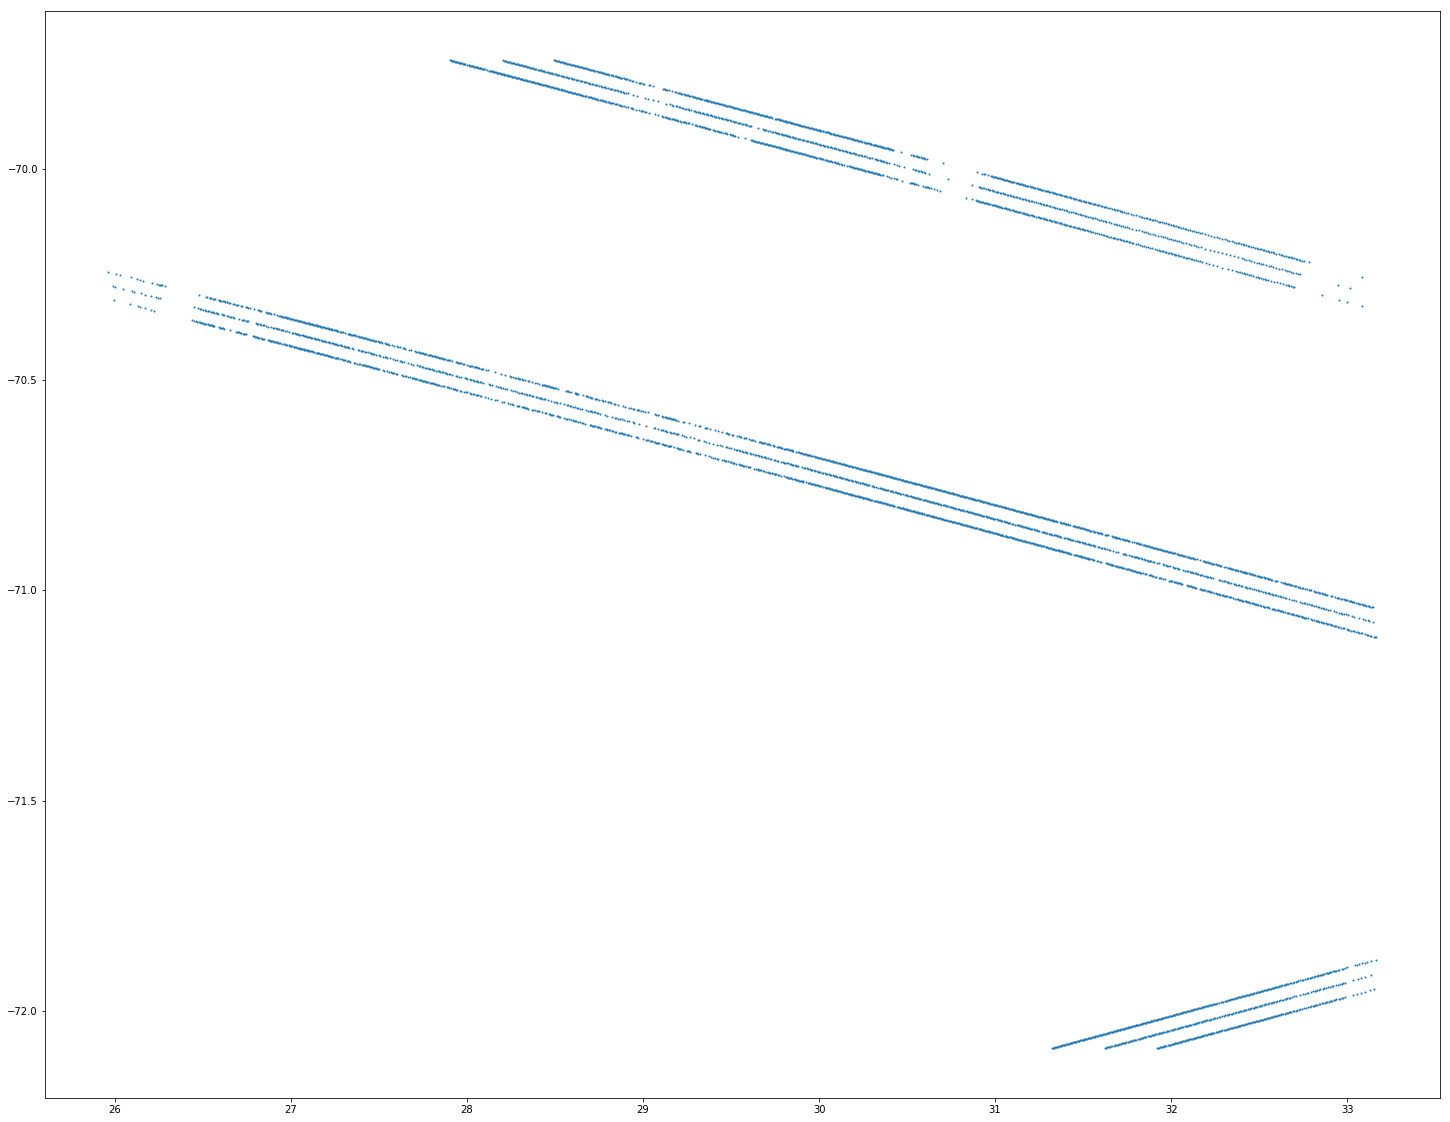

In [12]:
plt.scatter( pho.lat_ph[::1000] , pho.lon_ph[::1000], s = 1 )

In [67]:
np.random.seed(666)

N = 1000
atl3 = pho.sample(n = N)[["lon_ph","lat_ph"]]

In [68]:
atl3_dict = {}
atl3_dict_outliers = {}

for i in atl3.index:
    
    lon, lat = atl3.loc[i][["lon_ph", "lat_ph"]]
    
    atl3_dict[i] = df_filter(pho, lat, lon, 100, lat_col_name = "lat_ph", lon_col_name = "lon_ph")
    
    atl3_dict_outliers[i] = atl3_dict[i][ atl3_dict[i].h_ph < np.median(atl3_dict[i].h_ph) - 1 * np.std(atl3_dict[i].h_ph) ] 

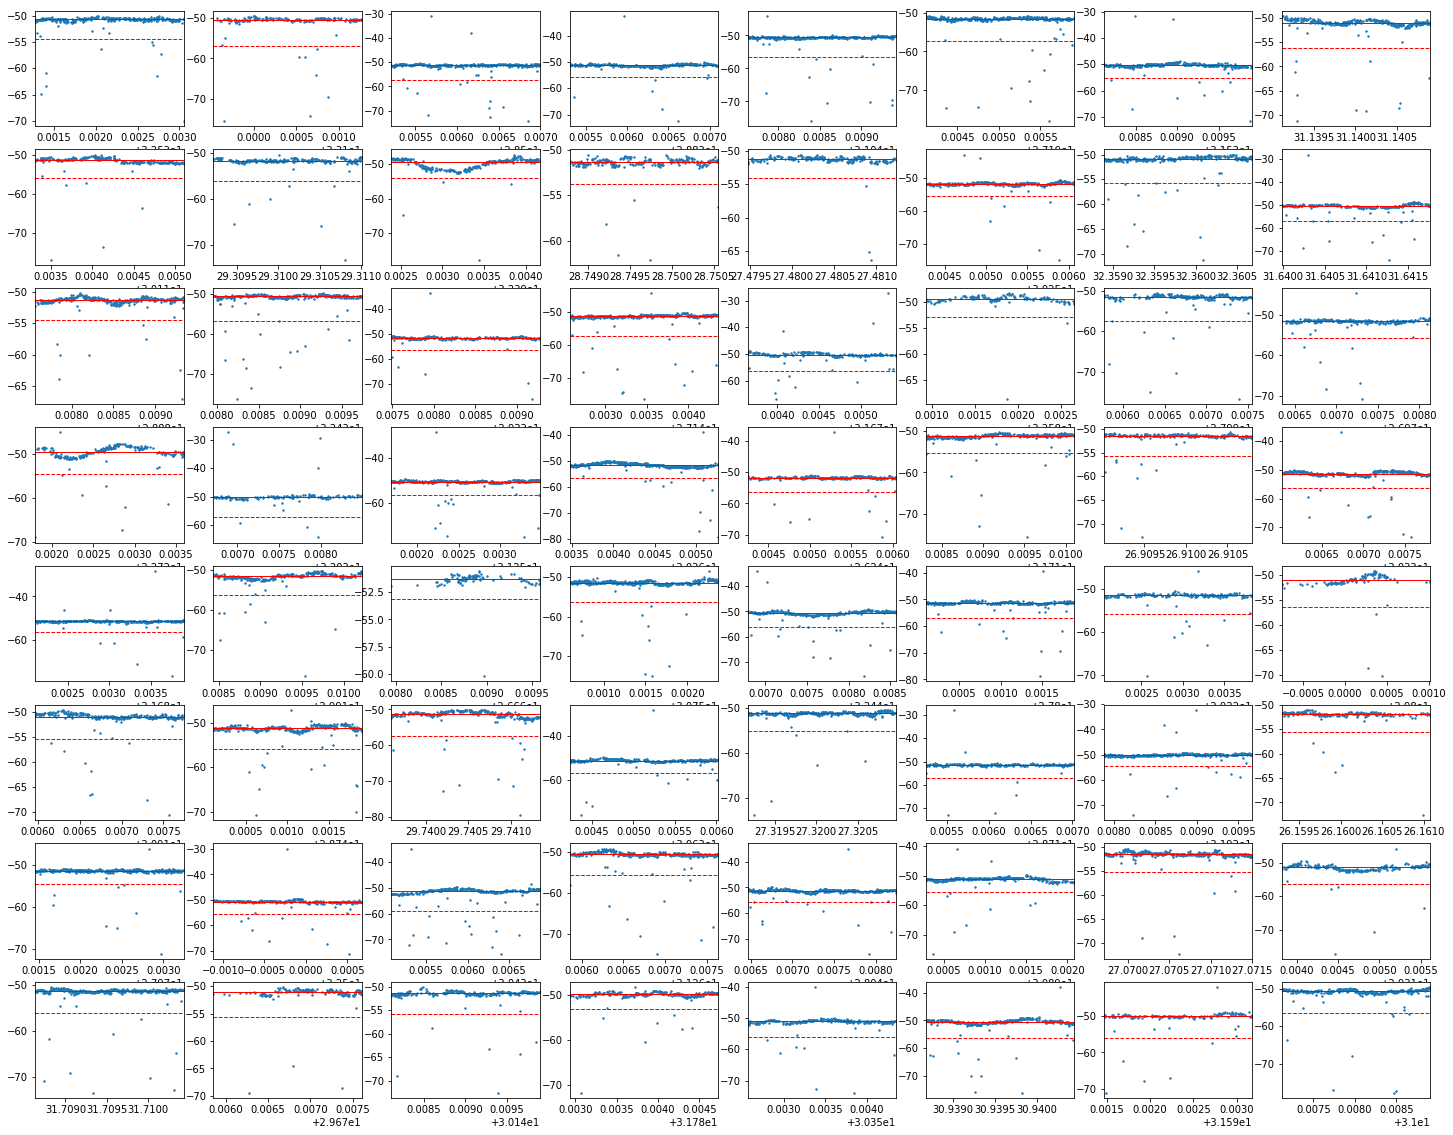

In [18]:
rows = 8
cols = 8

sample_id = sample(atl3_dict.keys(), rows * cols)

for j, i in enumerate(sample_id):
    plt.subplot(rows, cols, j+1)
    plt.scatter( atl3_dict[i].lat_ph, atl3_dict[i].h_ph, s = 2 )
    plt.xlim([min(atl3_dict[i].lat_ph), max(atl3_dict[i].lat_ph) ])
    plt.axhline(y = np.median(atl3_dict[i].h_ph), c = 'red', lw = 1)
    plt.axhline(y = np.median(atl3_dict[i].h_ph) - 2 * np.std(atl3_dict[i].h_ph), c = 'red', lw = 1, ls = "--")

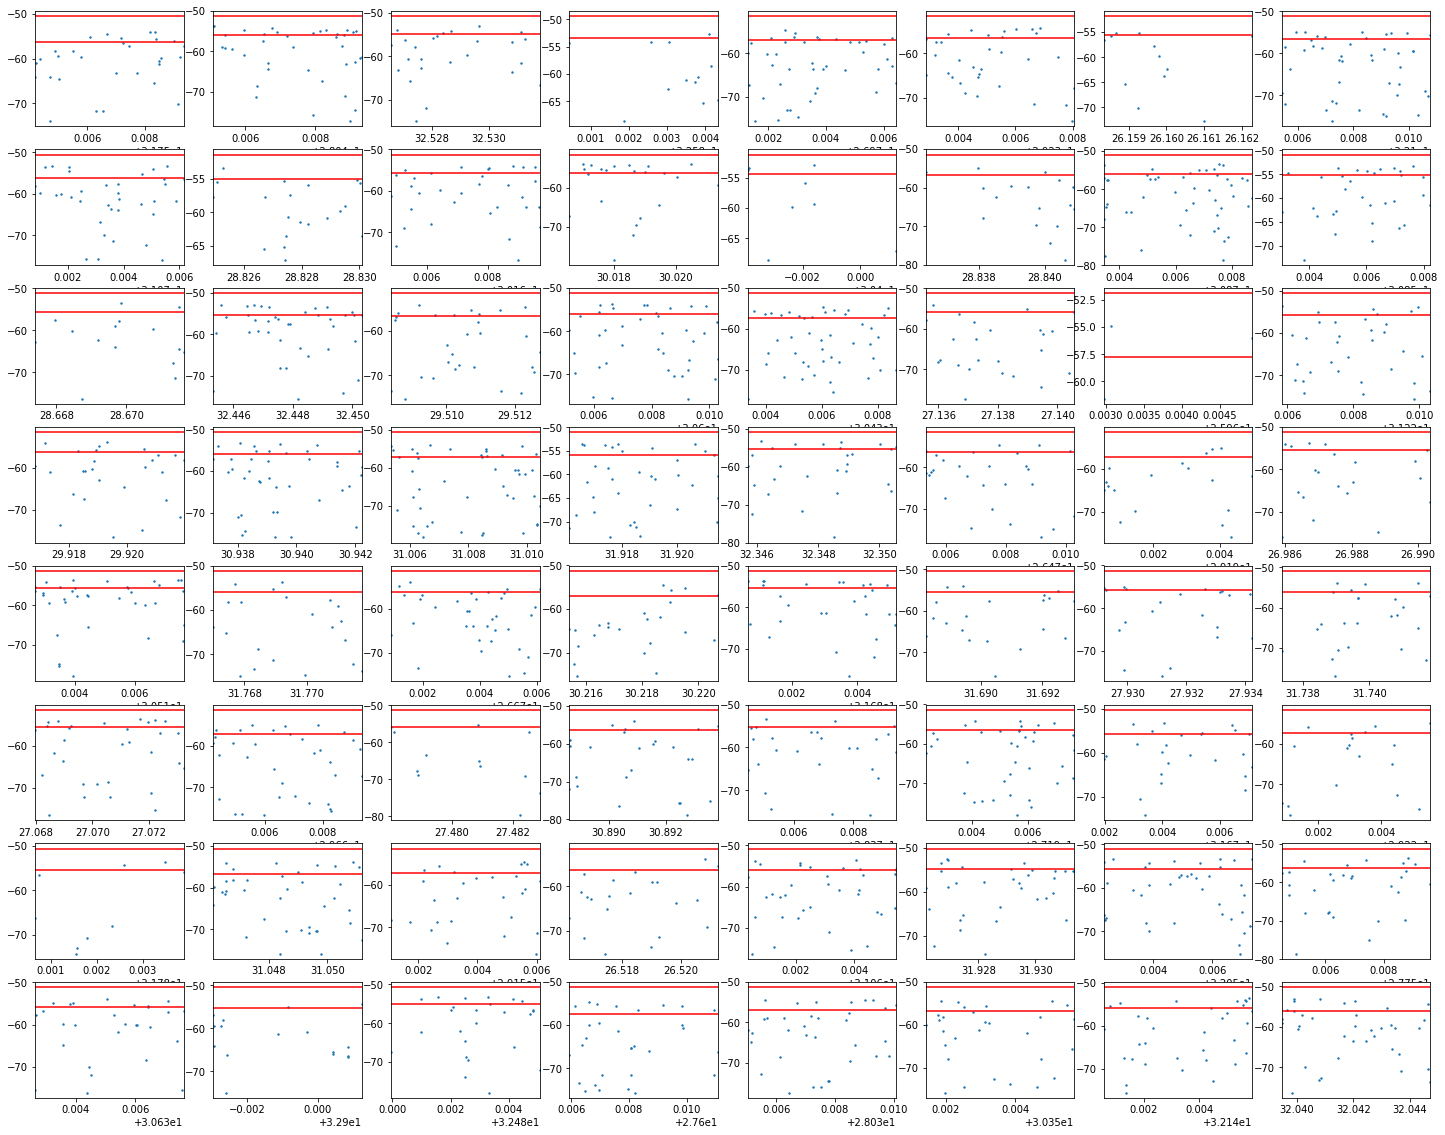

In [38]:
for j, i in enumerate(sample_id):
    plt.subplot(rows, cols, j+1)
    plt.scatter( atl3_dict_outliers[i].lat_ph, atl3_dict_outliers[i].h_ph, s = 2 )
    plt.xlim([min(atl3_dict_outliers[i].lat_ph), max(atl3_dict_outliers[i].lat_ph) ])
    plt.axhline(y = np.median(atl3_dict[i].h_ph), c = 'red')
    plt.axhline(y = np.median(atl3_dict[i].h_ph) - 2 * np.std(atl3_dict[i].h_ph), c = 'red')  

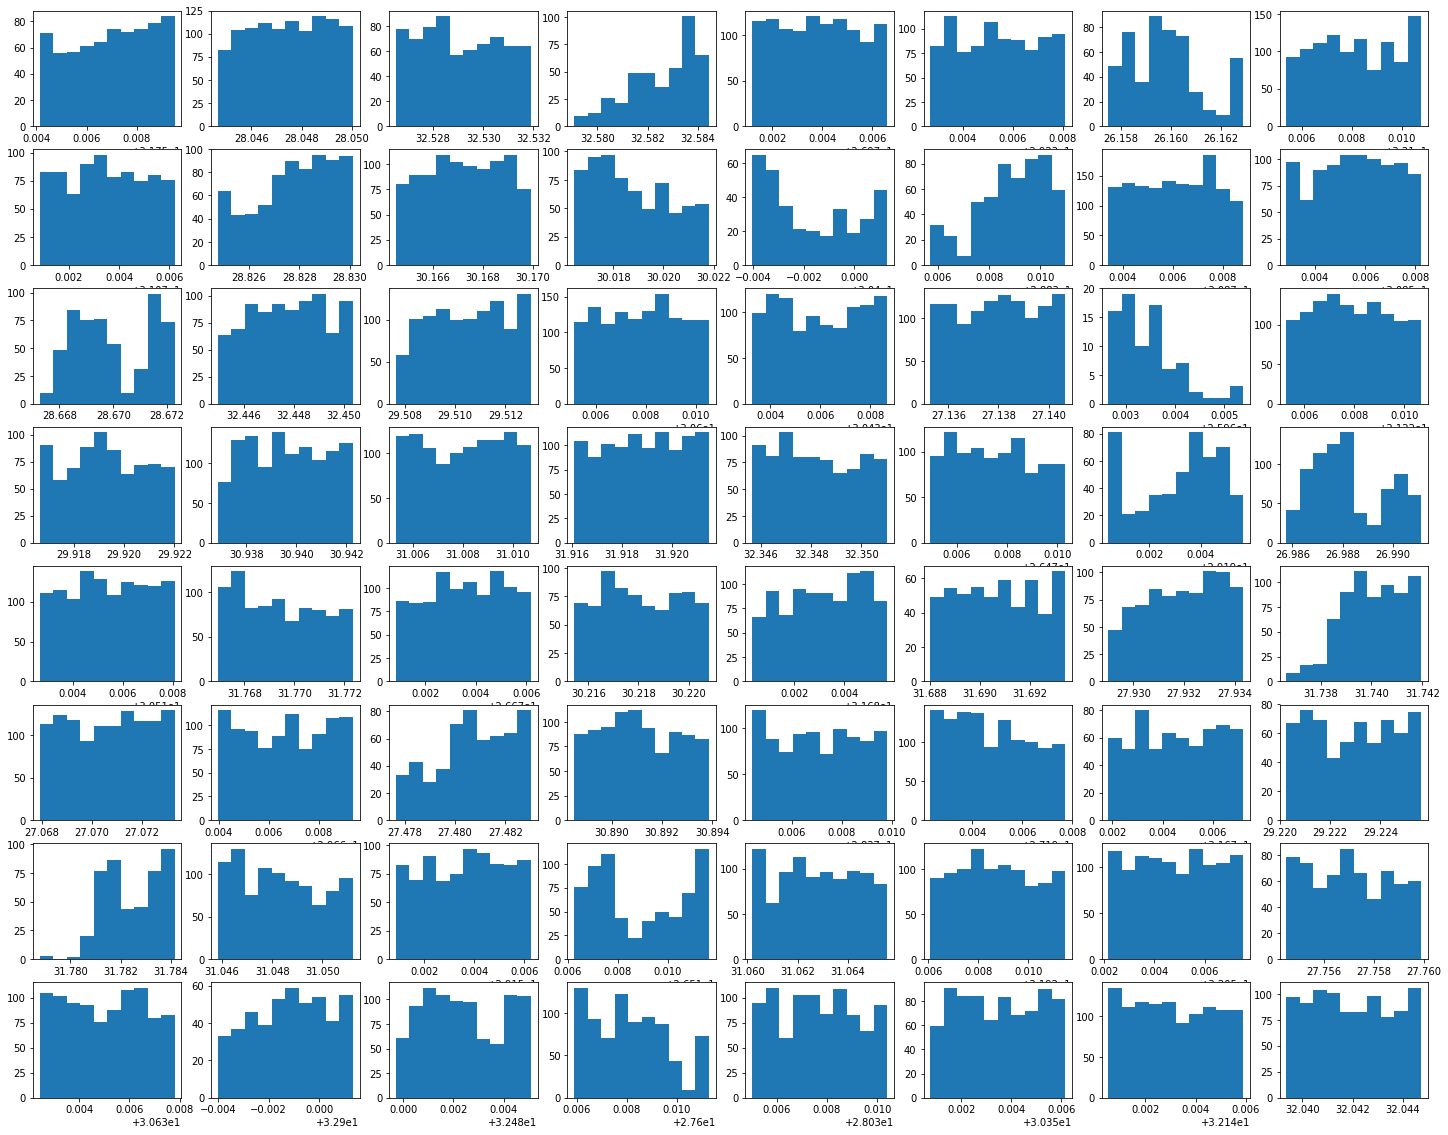

In [39]:
rows = 8
cols = 8

for j, i in enumerate(sample_id):
    plt.subplot(rows, cols, j+1)
    plt.hist( atl3_dict[i].lat_ph, 10 )

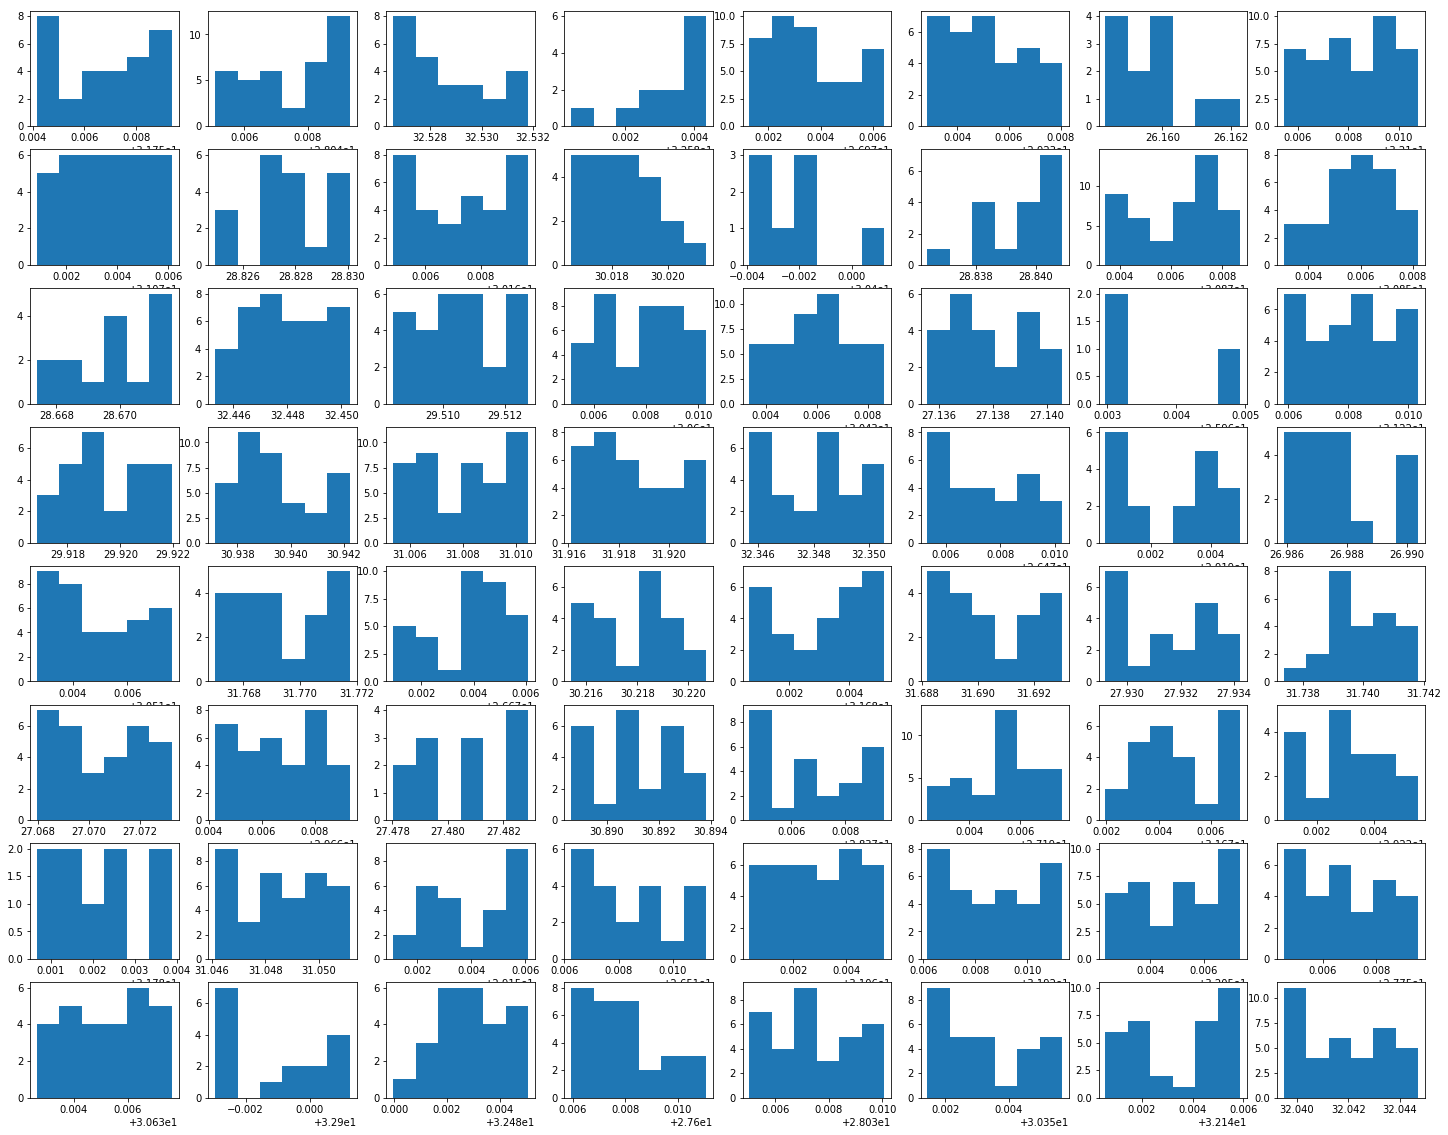

In [40]:
for j, i in enumerate(sample_id):
    plt.subplot(rows, cols, j+1)
    plt.hist( atl3_dict_outliers[i].lat_ph, 6 )

In [45]:
np.quantile([1,2,3], q= 0.9)

2.8000000000000003

In [64]:
atl3["interquantile"] = None
atl3["n_ph"] = None

for i in atl3.index:
    
    atl3.loc[i, "interquantile"] = interquantile(atl3_dict[i].h_ph)
    atl3.loc[i, "n_ph"] = atl3_dict[i].shape[0]

In [65]:
atl3

,lon_ph,lat_ph,interquantile,n_ph
4494309,-69.833529,29.338381,1.15595,281
4570321,-69.879974,29.757161,1.34872,307
3347562,-69.754200,28.025625,0.84251,395
1147766,-70.709799,29.919329,2.13305,296
323260,-70.724566,29.753594,1.75511,351
...,...,...,...,...
3004734,-72.024778,32.482402,1.15563,314
3235213,-70.370959,26.847102,1.02815,227
2105004,-70.798742,31.012053,2.96201,325
2852228,-72.033359,32.107248,1.32627,254


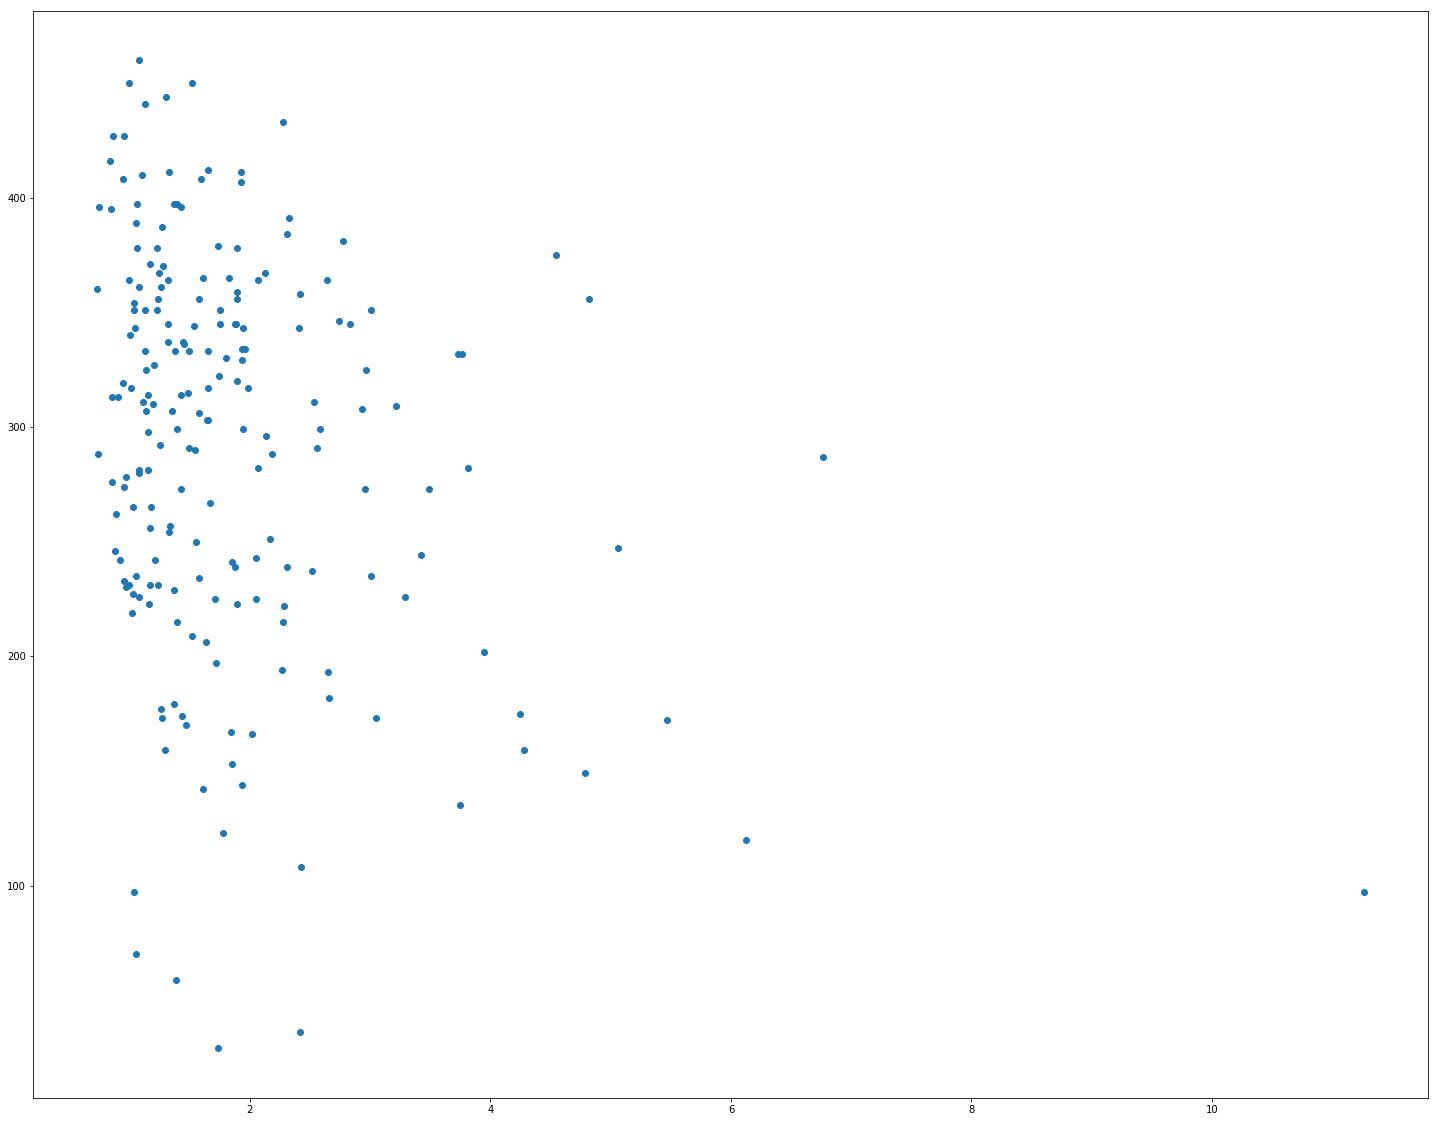

In [66]:
plt.scatter(atl3.interquantile, atl3.n_ph)

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def MSE_linear(x, y):
    
    """
        - x: vector of features
        - y: vector of labels
    """
    
    reg = LinearRegression().fit(x.reshape((-1,1)), y.reshape((-1,1)))
    hat_y = reg.predict(x.reshape((-1,1)))
    
    return mean_squared_error(hat_y, y.reshape((-1,1)))

In [70]:
atl3["linear_MSE"] = None

for i in atl3.index:
    
    atl3.loc[i, "linear_MSE"] = MSE_linear( np.array(atl3_dict[i].lon_ph), np.array(atl3_dict[i].h_ph) )

In [51]:
atl3.linear_MSE

4494309    5.97329
4570321    4.37866
3347562    7.60536
1147766    5.12695
323260     4.17953
            ...   
3004734    5.42713
3235213    8.05946
2105004    8.21588
2852228    7.68107
4024011    1.36484
Name: linear_MSE, Length: 200, dtype: object

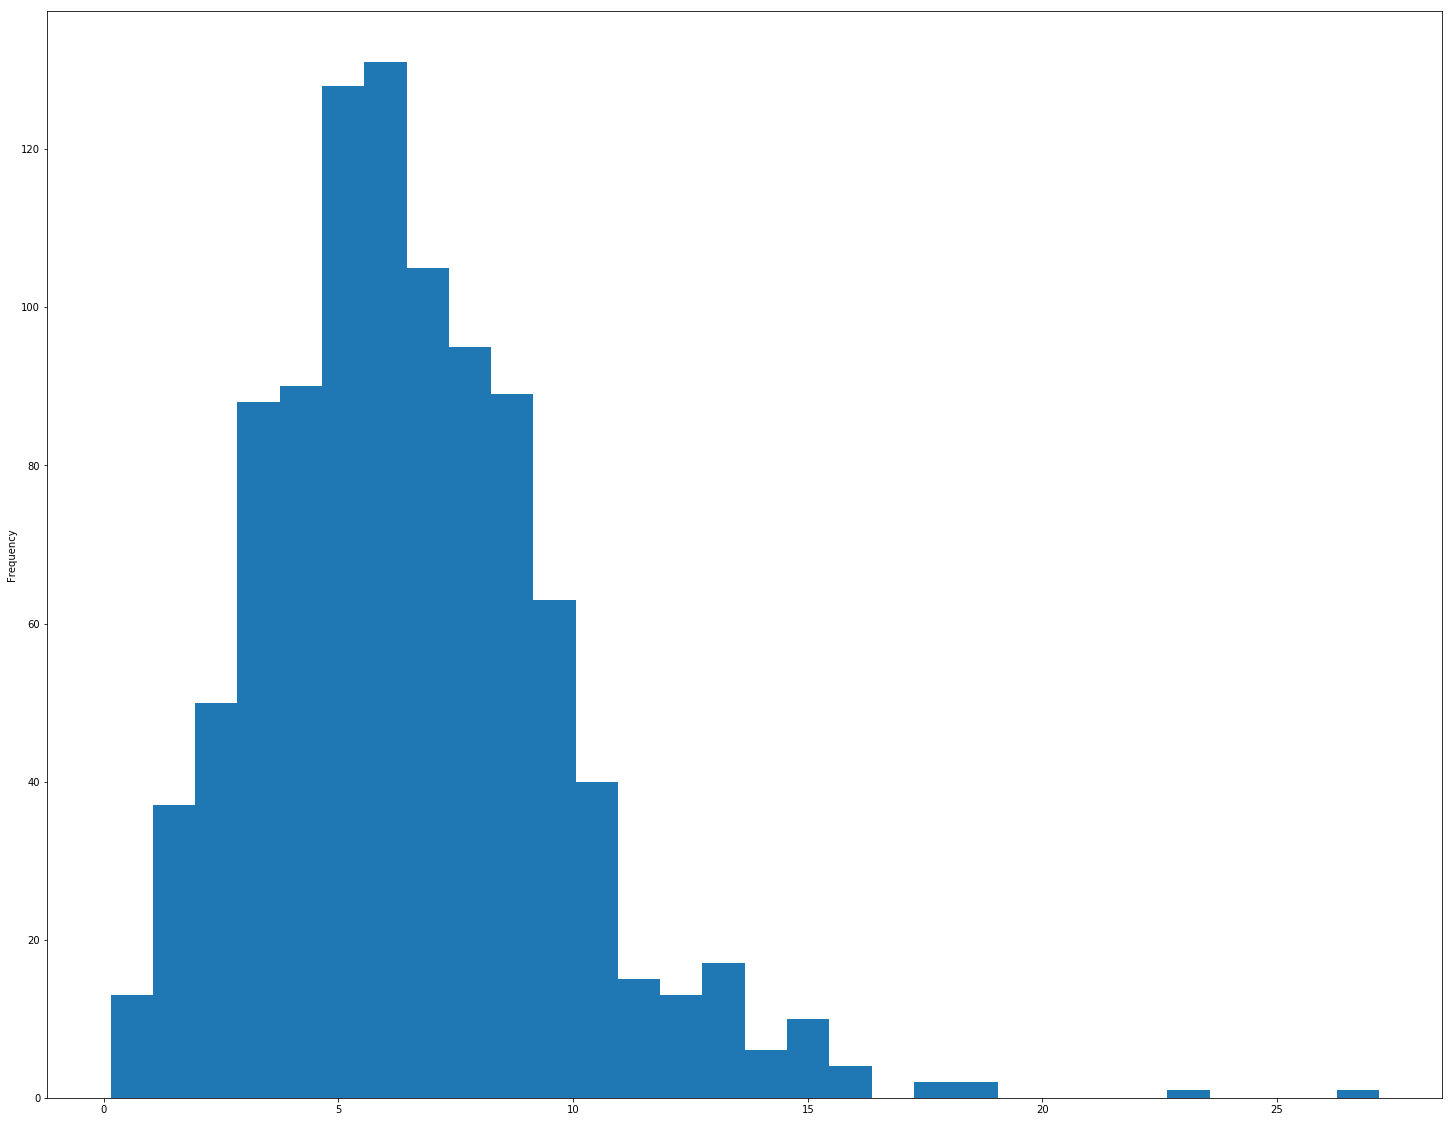

In [71]:
atl3["linear_MSE"].plot.hist(bins = 30)

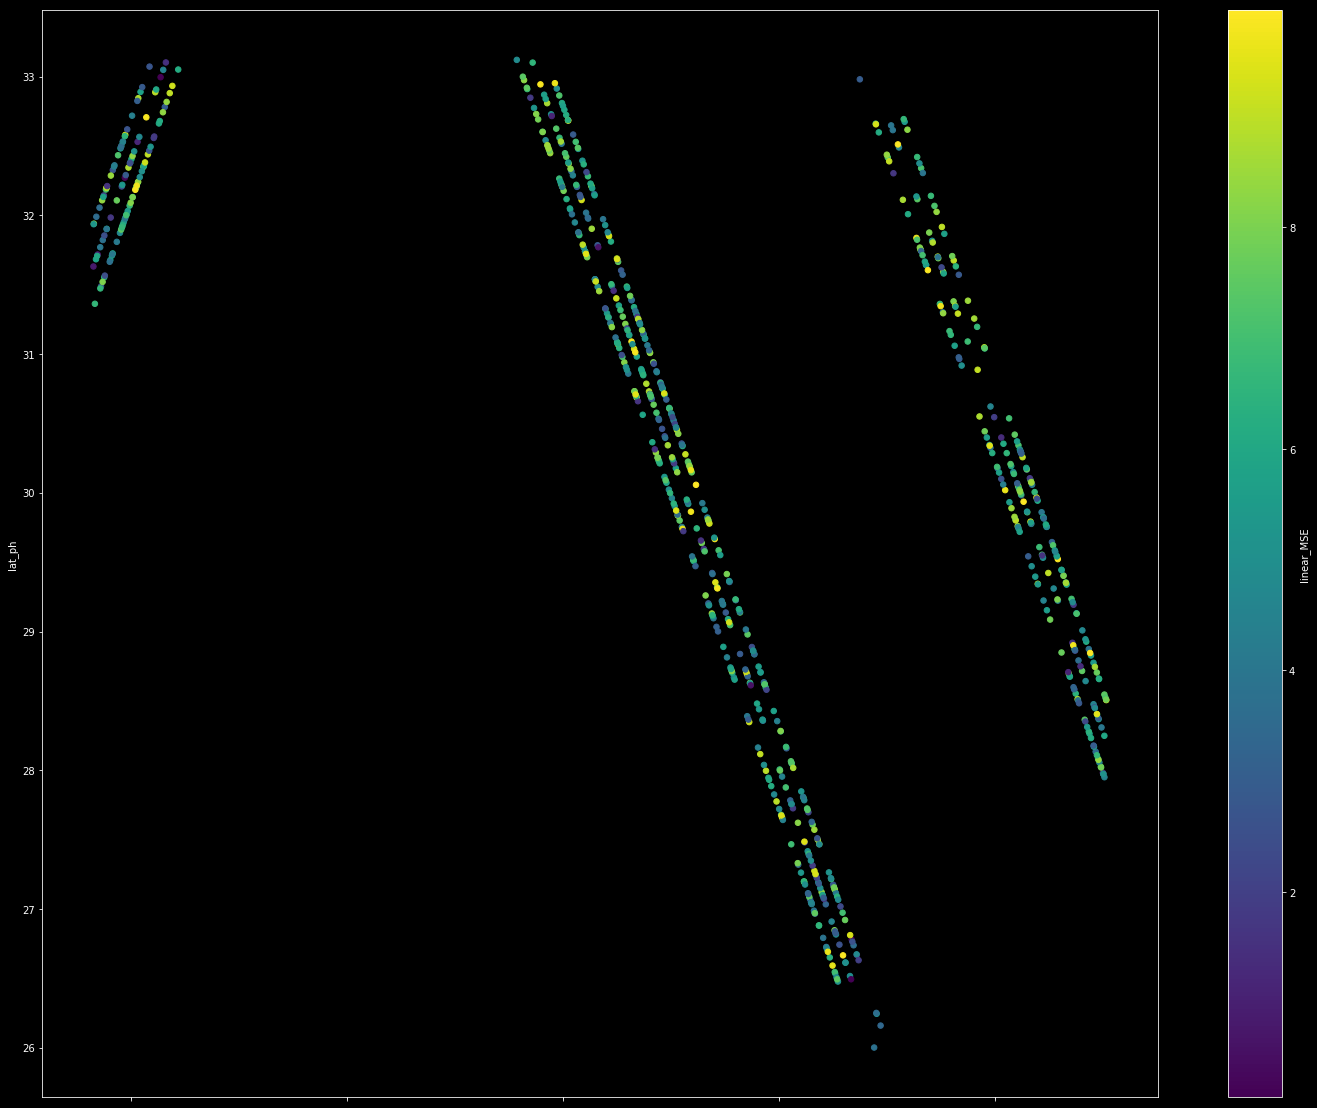

In [79]:
with plt.style.context('dark_background'):
    atl3[atl3["linear_MSE"] < 10].plot.scatter(x = "lon_ph", y = "lat_ph", c = "linear_MSE", colormap = "viridis", s = 30)

In [86]:
atl3_goodfit = atl3[ atl3["linear_MSE"] < 5 ]
atl3_badfit  = atl3[ atl3["linear_MSE"] > 10 ]

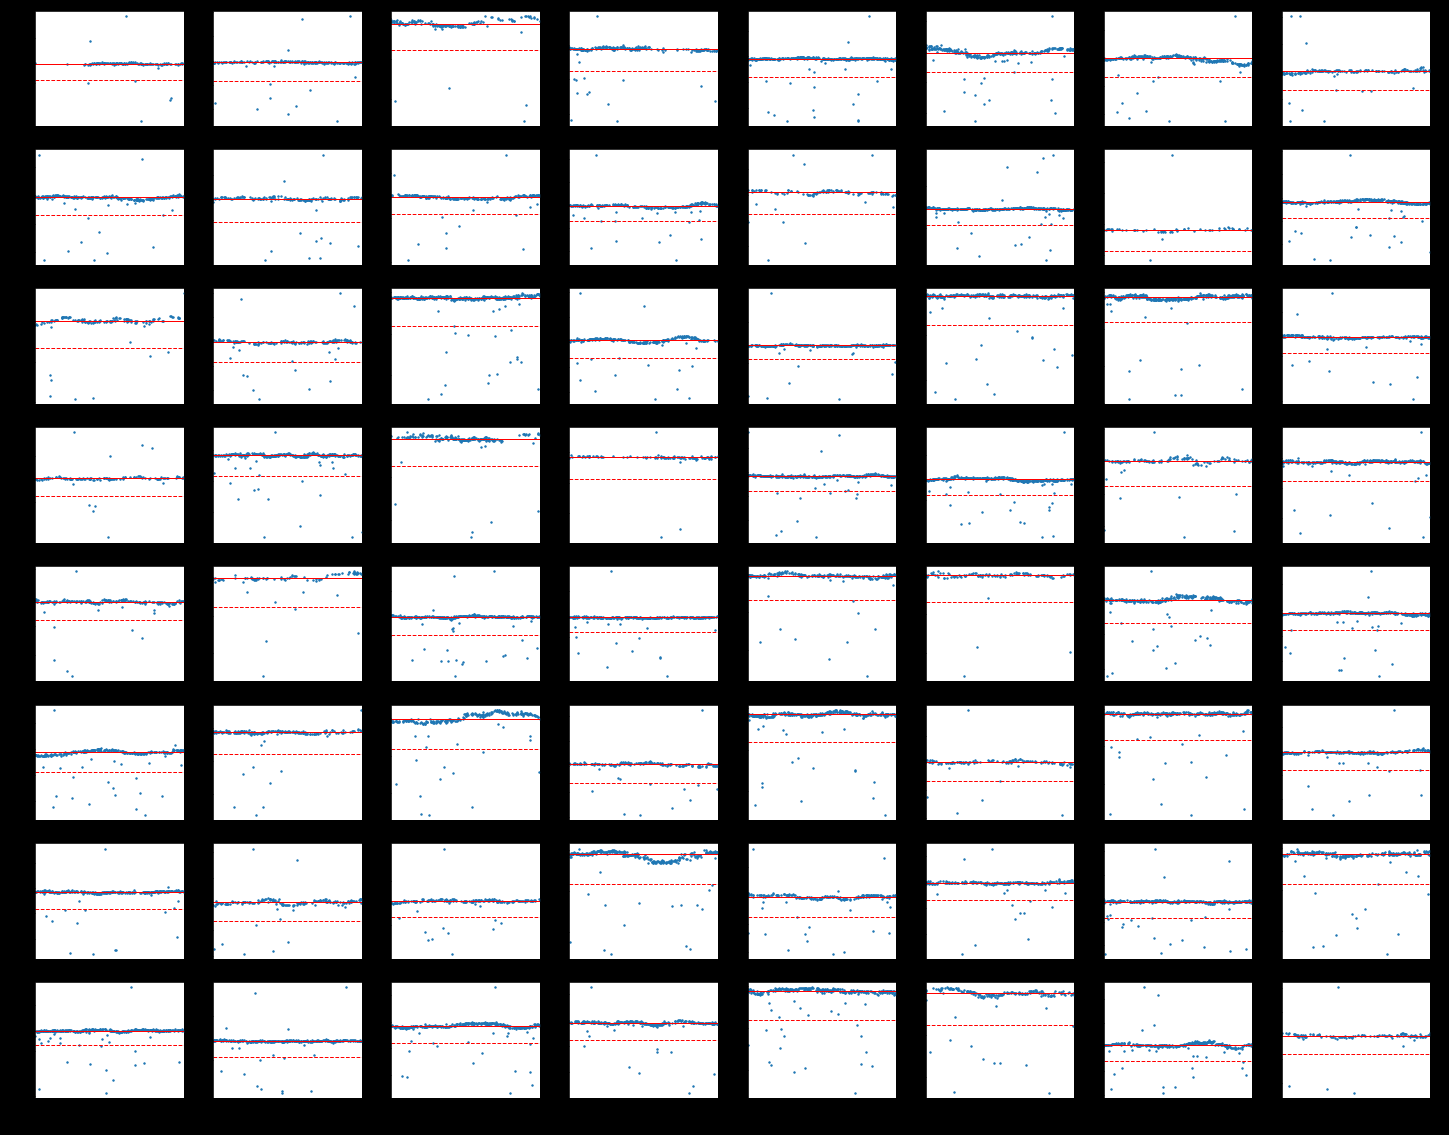

In [87]:
rows = 8
cols = 8

sample_id = sample(list(atl3_goodfit.index), rows * cols)
sample_id = sample(list(atl3_badfit.index), rows * cols)


for j, i in enumerate(sample_id):
    plt.subplot(rows, cols, j+1)
    plt.scatter( atl3_dict[i].lat_ph, atl3_dict[i].h_ph, s = 2 )
    plt.xlim([min(atl3_dict[i].lat_ph), max(atl3_dict[i].lat_ph) ])
    plt.axhline(y = np.median(atl3_dict[i].h_ph), c = 'red', lw = 1)
    plt.axhline(y = np.median(atl3_dict[i].h_ph) - 2 * np.std(atl3_dict[i].h_ph), c = 'red', lw = 1, ls = "--")

In [83]:
np.array(atl3_goodfit.index)

array([4570321,  323260, 2912980, 3338177,  957740, 2179391, 3284625,
       1056877,   58726, 1764518, 1452813, 1491656, 2359614,  679873,
       3083720,  724569, 3619451, 2904486, 4591378, 2076457, 1812012,
       2995817, 2756492, 2114684, 3181482, 3256887, 3459037, 4471660,
       3285258, 2794650,  204819, 1998748, 2017830, 3938526, 1779975,
       3354527, 4067918, 3065994,  156288, 3971279, 1883111, 3184238,
       4097291, 2051595, 3130223, 4173393,  352109,  405575,   14680,
       4647794, 2705284, 2656499, 4204183, 4058405, 4459070, 3905223,
       3984217,  484173, 1411509, 3240567,  934543, 4443480,  344358,
       3182813, 3367508, 4028898, 4024011, 4669535,  492199,  923644,
        832639, 1082866, 4506044, 1459705,  656781, 1233122, 2926860,
         10031, 1044044, 1667547, 2896071,  523619, 1096243, 1015534,
       4609925, 1727949, 1777090,  873795, 1752064, 1758265,  265660,
       1818743, 1450792, 3150106,  252462, 3677442,  605219,  689470,
       3333111,   24